In [18]:
import os
import numpy as np
import pandas as pd
import torch
import pickle
import sklearn
from torch.utils.data import Dataset
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
import matplotlib.pyplot as plt

In [19]:
# Load in 3 data sets from specification
set_a = ["", "s1", "s10"]
set_b = ["s5", "m5", "l5"]
data_type = "XX"

# Initialize lists to store dataframes
targets_a = []
targets_b = []

# Load in data for each set in set_a
for set in set_a:
    if set == "":
        noise_data = ""
    else:
        noise_data = "_" + set
    targets_a.append(pd.read_csv(f"LE_{data_type}_comps_train{noise_data}.csv", header=None, index_col=0))

# Repeat for set_b
for set in set_b:
    if set == "":
        noise_data = ""
    else:
        noise_data = "_" + set
    targets_b.append(pd.read_csv(f"LE_{data_type}_comps_train{noise_data}.csv", header=None, index_col=0))

# Load labels
train_labels = pd.read_csv("param_train.csv", header=None, index_col=0)
test_labels = pd.read_csv("param_test.csv", header=None, index_col=0)

In [20]:
# Do the data split for each set
### Split into a test-train datasets
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

split_ratio = 0.9

# Split the dataset into train and test sets for each target in set_a
train_targets_a = []
test_targets_a = []

for target in targets_a:
    train_target, test_target = train_test_split(target, test_size=split_ratio, random_state=123)
    train_targets_a.append(train_target)
    test_targets_a.append(test_target)

# Repeat for set_b
train_targets_b = []
test_targets_b = []

for target in targets_b:
    train_target, test_target = train_test_split(target, test_size=split_ratio, random_state=123)
    train_targets_b.append(train_target)
    test_targets_b.append(test_target)

# Split the labels into train and test sets
train_labels_split, test_labels_split = train_test_split(train_labels, test_size=split_ratio, random_state=123)

In [21]:
# Load in the GP models in set_a
GP_models_a = []
for set in set_a:
    if set == "":
        with open("XX_GP.pkl", "rb") as f:
            GP_models_a.append(pickle.load(f))
    else:
        with open(f"{set}_noisy_{data_type}_GP.pkl", "rb") as f:
            GP_models_a.append(pickle.load(f))


GP_models_b = []
for set in set_b:
    if set == "":
        with open("XX_GP.pkl", "rb") as f:
            GP_models_b.append(pickle.load(f))
    else:
        with open(f"{set}_noisy_{data_type}_GP.pkl", "rb") as f:
            GP_models_b.append(pickle.load(f))


/opt/anaconda3/envs/R21_env/lib/python3.13/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [22]:
# For each GP Model, predict on the test set
predictions_a = []
for ind, GP_model in enumerate(GP_models_a):
    y_pred, y_std = GP_model.predict(test_labels, return_std=True)
    predictions_a.append(y_pred)

predictions_b = []
for ind, GP_model in enumerate(GP_models_b):
    predictions_b.append(GP_model.predict(test_labels))



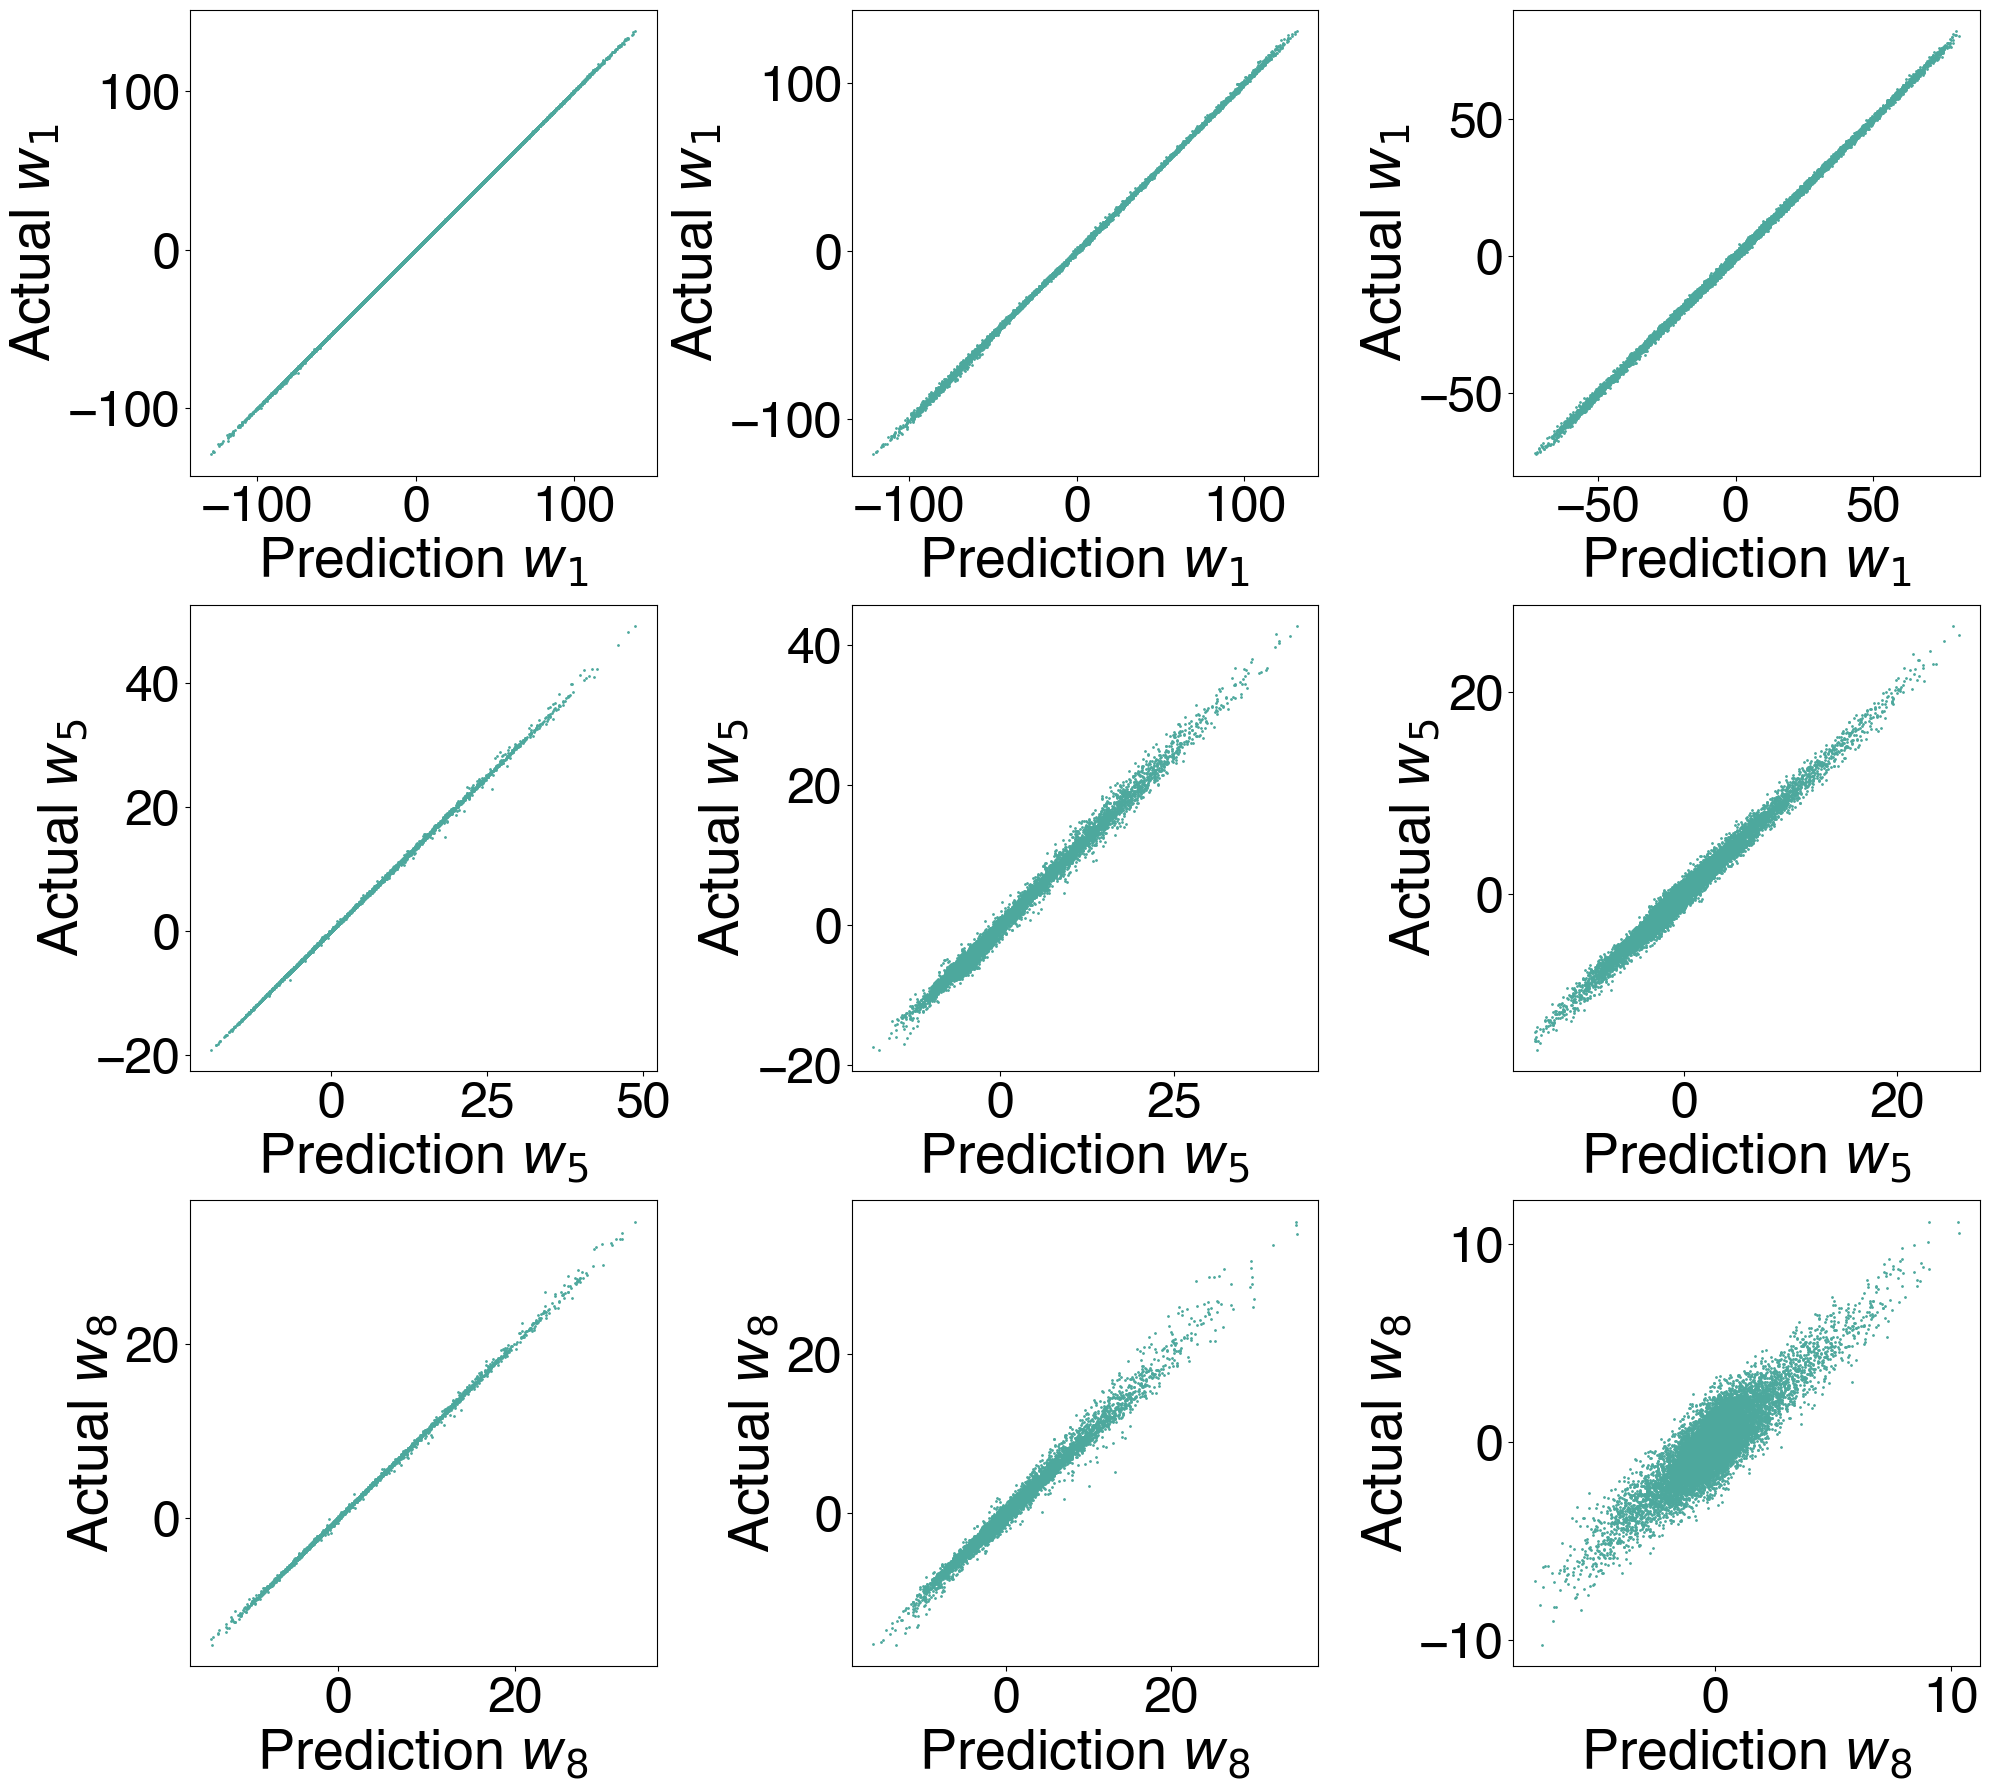

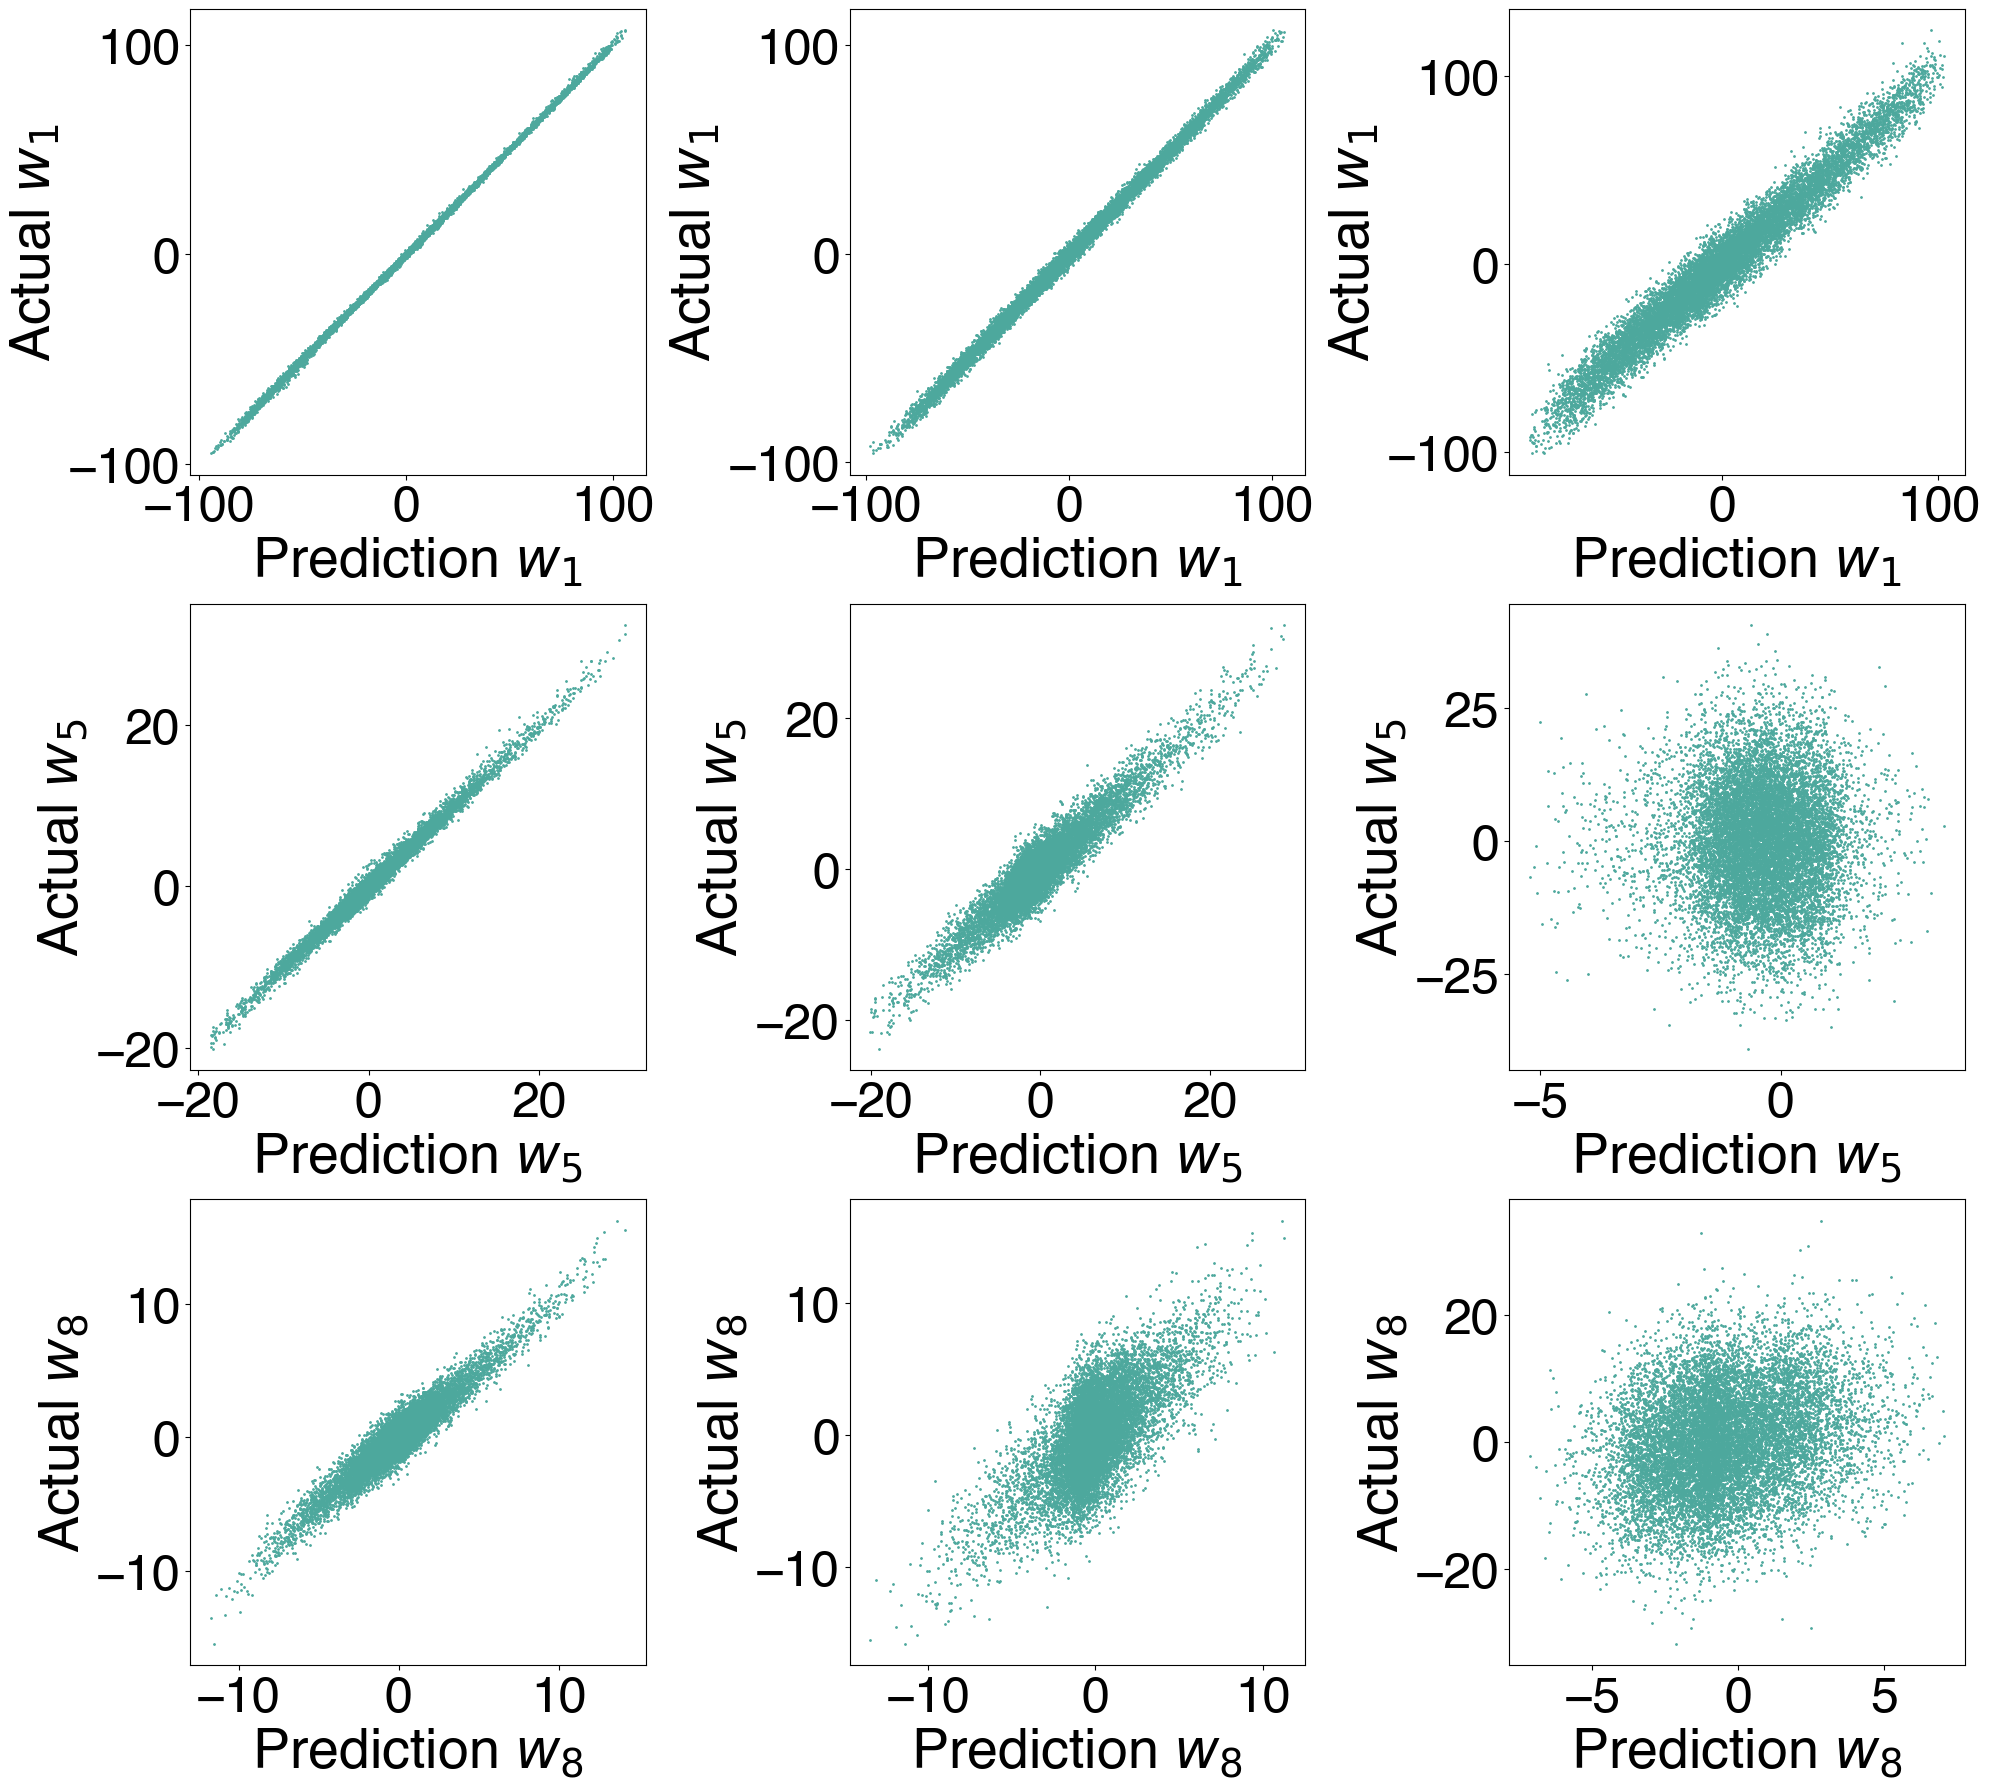

In [27]:
def plot_predictions_vs_actuals(GP_models, labels, label_set, target_set):
    # Set up the plotting parameters
    dot_size = 1
    font_size = 40
    tick_font_size = 36
    font_color = '#4DA89D'
    plt.rcParams.update({'font.family': 'Helvetica'})

    # Create a 3x3 subplot grid
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

    # Components to plot (1st, 5th, and 8th)
    components = [0, 4, 7]  # 0-based indexing
    models = GP_models  # Using first three models from set_a
    model_labels = label_set  # Labels for the models

    # Loop through components (rows)
    for i, comp in enumerate(components):
        # Loop through models (columns)
        for j, (model, label) in enumerate(zip(models, model_labels)):
            # Make predictions for this model
            y_pred = model.predict(labels)
            y_test = np.array(target_set[j])
            
            # Sort the data for proper filling
            sorted_indices = np.argsort(y_pred[:, comp])
            sorted_predictions = y_pred[sorted_indices, comp]
            sorted_actuals = y_test[sorted_indices, comp]
            
            # Create the scatter plot
            scatter = axes[i][j].scatter(sorted_predictions, sorted_actuals, 
                                       s=dot_size, color=font_color)
            
            # Set labels
            axes[i][j].set_xlabel(f"Prediction $w_{comp+1}$", fontsize=font_size)
            axes[i][j].set_ylabel(f"Actual $w_{comp+1}$", fontsize=font_size)
            axes[i][j].tick_params(axis='both', which='major', labelsize=tick_font_size)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# Plot for set_a
plot_predictions_vs_actuals(GP_models_a, test_labels_split, set_a, test_targets_a)

# Plot for set_b
plot_predictions_vs_actuals(GP_models_b, test_labels_split, set_b, test_targets_b)